# NB04 &ndash; Signal filtering strategies

Mario Fiorani suggested filtering the WB signal by applying a moving average (convolving with a properly normalized box filter) in order to extract the spikes.
Thie notebook explores some of the side-effects of this strategy, and some of the differences to FFT-based filtering.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Box-filtering" data-toc-modified-id="Box-filtering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Box filtering</a></span><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Preliminaries</a></span></li><li><span><a href="#Sinusoidal-LFP-with-Gaussian-spikes" data-toc-modified-id="Sinusoidal-LFP-with-Gaussian-spikes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sinusoidal LFP with Gaussian spikes</a></span><ul class="toc-item"><li><span><a href="#Interactive-case" data-toc-modified-id="Interactive-case-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Interactive case</a></span></li><li><span><a href="#Relative-error-as-function-of-filter-size-and-spike-magnitude" data-toc-modified-id="Relative-error-as-function-of-filter-size-and-spike-magnitude-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Relative error as function of filter size and spike magnitude</a></span></li></ul></li></ul></li></ul></div>

## Setup

In [1]:
%matplotlib inline

import ipywidgets as ipw
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as npr

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rc
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve
from typing import List, Tuple

In [2]:
rc('figure', figsize=(15, 4))

In [3]:
def time_to_samples(t):
    return np.round(t * rate).astype(int)

def window(width):
    samples = int(width * rate)
    return np.ones(samples) / samples

def sinusoid(freqs, amp=1):
    return np.sum([amp * np.sin(tau * f * time) for f in freqs], axis=0)

def sinusoid_def(freqs, amp=1):
    return fr'{amp}\left(' + '+'.join(fr'\sin(2\pi \cdot {f} x)' for f in freqs) + r'\right)'

cycles = 10
rate = 100
samples = time_to_samples(cycles) + 1
tau = 2 * np.pi
time = np.linspace(0, cycles, samples)

## Box filtering
### Preliminaries

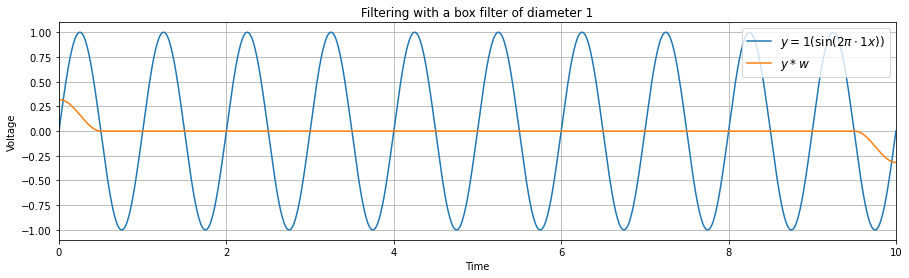

In [4]:
slow=[1]
diameter=1

win = window(diameter)
signal = sinusoid(slow)
signal_filtered = fftconvolve(signal, win, mode='same')

plt.plot(time, signal, label=f'$y = {sinusoid_def(slow)}$')
plt.plot(time, signal_filtered, label='$y * w$')

plt.title(f'Filtering with a box filter of diameter {diameter}')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.xlim(time[0], time[-1])
plt.grid()
plt.legend(fontsize='large');

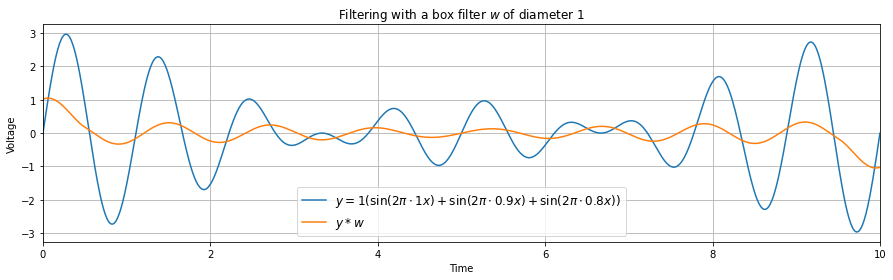

In [5]:
slow=[1, 0.9, 0.8]
diameter=1

win = window(diameter)
signal = sinusoid(slow)
signal_filtered = fftconvolve(signal, win, mode='same')

plt.plot(time, signal, label=f'$y = {sinusoid_def(slow)}$')
plt.plot(time, signal_filtered, label='$y * w$')

plt.title(f'Filtering with a box filter $w$ of diameter {diameter}')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.xlim(time[0], time[-1])
plt.grid()
plt.legend(fontsize='large');

### Sinusoidal LFP with Gaussian spikes
#### Interactive case

In [6]:
def error_study(noise_amplitude: (0.01, 0.5, 0.01) = 0.1, diameter: (0.05, 1.0, 0.05) = 0.25):
    slow=[1, 0.9, 0.8, 0.7, 0.6]
    fast = [20]

    win = window(diameter)
    lfp = sinusoid(slow)
    spk = noise_amplitude * np.max(np.abs(lfp)) * (2 * np.random.random(samples) - 1)
    signal = lfp + spk
    signal_filtered = fftconvolve(signal, win, mode='same')
    spk_retrieved = signal - signal_filtered
    spk_error = (spk - spk_retrieved) / spk
    median_abs_spk_error = np.median(np.abs(spk_error))
    q1_abs_spk_error = np.quantile(np.abs(spk_error), 0.25)
    q3_abs_spk_error = np.quantile(np.abs(spk_error), 0.75)

    plt.plot(time, signal, label=f'$y = {sinusoid_def(slow, 1.0)}$ + SPK')
    plt.plot(time, signal_filtered, label='$y * w$')

    plt.title(f'Filtering with a box filter $w$ of diameter {diameter}')
    plt.xlabel('Time')
    plt.ylabel('Voltage')
    plt.xlim(time[0], time[-1])
    plt.ylim(-6, 6)
    plt.grid()
    plt.legend()

    plt.figure()
    plt.plot(time, np.abs(spk_error), label=r'Rel. error $= \frac{{\rm SPK} - (y - y * w)}{{\rm SPK}}$')

    plt.axhline(1, color='black')
    plt.axhline(median_abs_spk_error, color='C2', label=f'Error median = {median_abs_spk_error:.2f}')
    plt.fill_between(time, q1_abs_spk_error, q3_abs_spk_error, color='C2', alpha=0.5, label='Error IQR')

    plt.title('Error in spike estimation')
    plt.xlabel('Time')
    plt.ylabel('Log. relative error')
    plt.xlim(time[0], time[-1])
    plt.ylim(0.0001, 10000)
    plt.yscale('log')
    plt.grid()
    plt.legend(fontsize='large')
    
ipw.interact(error_study);

interactive(children=(FloatSlider(value=0.1, description='noise_amplitude', max=0.5, min=0.01, step=0.01), Flo…

#### Relative error as function of filter size and spike magnitude

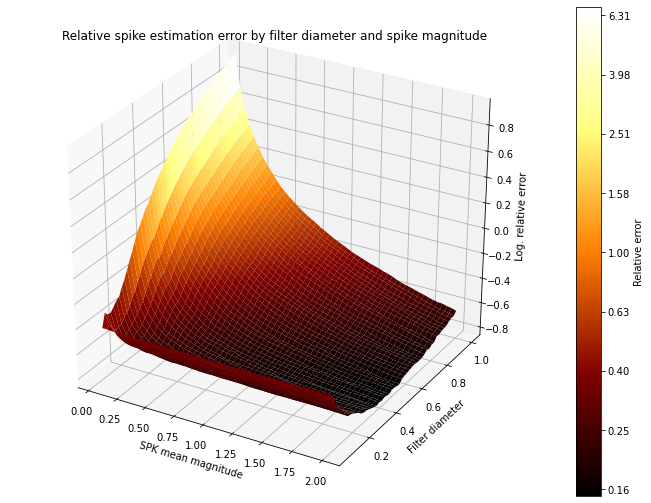

In [7]:
window_lengths = np.linspace(0.05, 1.00, 50)
noise_amplitudes = np.linspace(0.05, 2.0, 50)

lfp = sinusoid(slow)
spk = np.dot(noise_amplitudes[:,np.newaxis], np.max(np.abs(lfp)) * (2 * np.random.random(samples) - 1)[np.newaxis,:])
signal = lfp + spk
signal_filtered = np.zeros(window_lengths.shape + signal.shape)
spk_retrieved = np.zeros_like(signal_filtered)

for i, w in enumerate(window_lengths):
    for j, a in enumerate(noise_amplitudes):
        signal_filtered[i, j] = fftconvolve(signal[j], window(w), mode='same')
        
spk_retrieved = signal - signal_filtered
spk_error = (spk - spk_retrieved) / spk

mean_abs_spk_error = np.mean(np.abs(spk_error), axis=-1)
median_abs_spk_error = np.median(np.abs(spk_error), axis=-1)

X, Y = np.meshgrid(noise_amplitudes, window_lengths)

plt.figure(figsize=(12, 9))
axes = plt.gca(projection='3d')
mesh = axes.plot_surface(X, Y, np.log(median_abs_spk_error) / np.log(10), cmap='afmhot', antialiased=True)
axes.set_xlabel('SPK mean magnitude')
axes.set_ylabel('Filter diameter')
axes.set_zlabel('Log. relative error')
cbar = plt.colorbar(mesh)
cbar.set_label('Relative error')
cbar.set_ticks(cbar.get_ticks())
cbar.set_ticklabels([f'{x:.2f}' for x in 10**np.array(cbar.get_ticks())])
plt.title('Relative spike estimation error by filter diameter and spike magnitude')
plt.show()